## Stack Exchange: Popular Data Science Questions

(completed: 6/12/2020) 

Stack exchange is a web site where people get answers to their technical questions. [Their Data Science](https://datascience.stackexchange.com/) focuses website data science related questions. When asking a question, one should not repeatedly ask the same question that exists in the platform. The question should be specific to the topic and described with details to avoid vague questions. The home page shows questions sorted by date. Recent questions are shown first. There are tags and other filters to explore questions.

Instead of scraping the website, we can use a database provided by Stack Exchange. The database supports [SQL Server](https://data.stackexchange.com/datascience/query/new) language.

The table we are interested in is 'posts' table. It has questions and answers related fields.

>select id, posttypeid, creationdate, score, 
viewcount, tags, AnswerCount, favoriteCount

>from posts

>where year(creationdate)=2019
order by favoriteCount desc, answercount desc;

In [1]:
import pandas as pd
# Reading the csv
DS_data = pd.read_csv('2019_questions.csv') 

In [2]:
DS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null object
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


In [3]:
DS_data['Tags'].head()

0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object

FavoriteCount field has mostly null values. This means not all questions are marked as favorite. In this can we can consider them to have zero favorite marks. 
Additionally, CreationDate should be in datetime format. Favorite count should be in integer format.
Each tag in Tags field is wrapped with < and > characters. These should be removed and each tags should be separated by comma.

In [4]:
# some data cleaning to address issues stated above
DS_data['FavoriteCount'].fillna(0, inplace=True)
DS_data['FavoriteCount']=DS_data['FavoriteCount'].astype(int)
DS_data['Tags']=DS_data['Tags'].str.replace('<','').str.replace('>',',')
DS_data['CreationDate']=pd.to_datetime(DS_data['CreationDate'])

## Popular tags

In [5]:
# count of tag views
import numpy as np
tags_views ={}
tags_count={}
#DS_data[['Tags','ViewCount']].groupby('Tags').agg(np.sum).sort_values('ViewCount', ascending=False)
for i, row in DS_data.iterrows():
    for tag in row['Tags'].split(','):
        if tag in tags_views:
            tags_views[tag]+=row['ViewCount']
            tags_count[tag]+=1
        else:
            tags_views[tag]=0
            tags_count[tag]=0

In [6]:
# most viewed tags
sorted(tags_views.items(), key = lambda x: x[1], reverse=True)[:10]

[('', 1516292),
 ('python', 535934),
 ('machine-learning', 388478),
 ('keras', 268024),
 ('deep-learning', 233044),
 ('pandas', 200575),
 ('neural-network', 185341),
 ('scikit-learn', 128055),
 ('tensorflow', 119559),
 ('classification', 104396)]

In [7]:
# most used tags
sorted(tags_count.items(), key = lambda x: x[1], reverse=True)[:10]

[('', 8838),
 ('machine-learning', 2692),
 ('python', 1813),
 ('deep-learning', 1219),
 ('neural-network', 1054),
 ('keras', 934),
 ('classification', 684),
 ('tensorflow', 583),
 ('scikit-learn', 539),
 ('nlp', 492)]

In [8]:
# create viz (barchart)
tagviews_df=pd.DataFrame(list(tags_views.items()),columns = ['tags','views']) 
tagcount_df = pd.DataFrame(list(tags_count.items()),columns= ['tags', 'uses'])

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



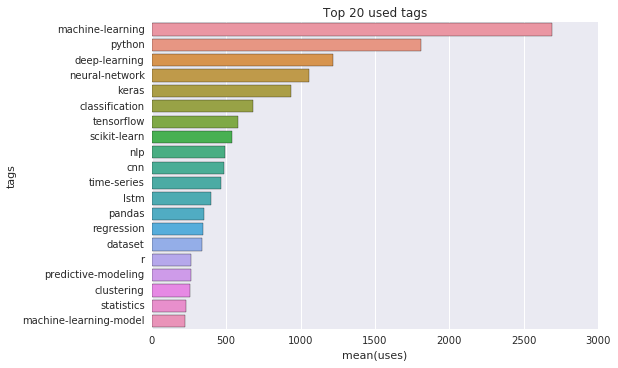

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.barplot(y=tagcount_df.sort_values('uses', ascending=False)['tags'][1:21], x=tagcount_df.sort_values('uses', ascending=False)['uses'][1:21])
plt.title('Top 20 used tags')

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



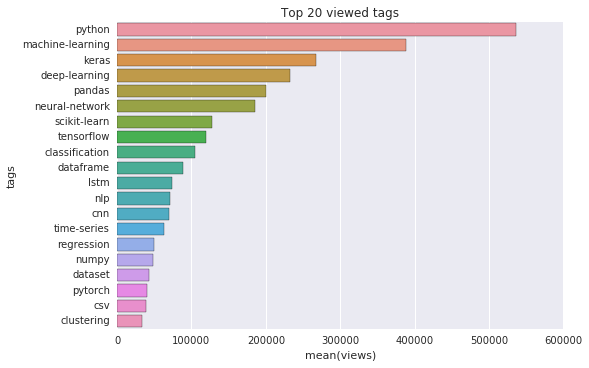

In [10]:
sns.barplot(y=tagviews_df.sort_values('views', ascending=False)['tags'][1:21], x=tagviews_df.sort_values('views', ascending=False)['views'][1:21])
plt.title('Top 20 viewed tags')

In [11]:
# check correlation between tag usage and views
# check which tags jointly exist in top 20 tag usage table and tag views table

In [12]:
uses = tagcount_df.sort_values('uses', ascending=False)[1:21]

In [13]:
views = tagviews_df.sort_values('views', ascending=False)[1:21]

In [14]:
uses_pair=pd.merge(uses, views, how='left', on='tags', right_index=True, left_index=True)

In [15]:
views_pair=pd.merge(uses, views, how='right', on='tags', right_index=True, left_index=True)

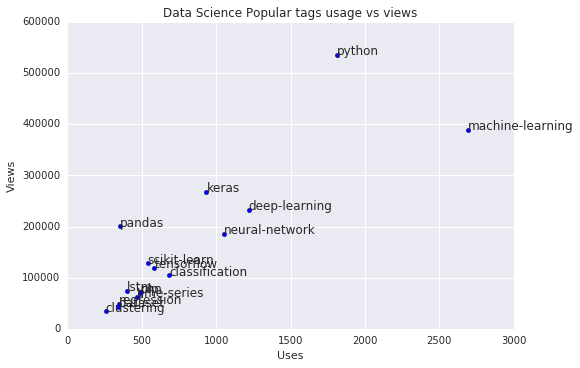

In [16]:
fig, ax = plt.subplots()
ax.scatter(x=views_pair['uses'], y=views_pair['views'])

for i, row in views_pair.iterrows():
    ax.annotate(row['tags'], (views_pair['uses'][i], views_pair['views'][i]))
plt.ylabel('Views')
plt.xlabel('Uses')
plt.title('Data Science Popular tags usage vs views')

The scatterplot illustrates that most used tag is 'machine-learning' and it is followed by 'python'. Most viewed tag is 'python' followed by 'machine-learning'.

In [17]:
# check Deep Learning tag popularity over time
dl = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

In [18]:
dl['Tags']=dl['Tags'].str.replace('<','').str.replace('>', ',')

In [19]:
dl['yearmonth'] = dl['CreationDate'].apply(lambda x: int(str(x.year)+str(x.month).zfill(2)))

In [20]:
#dl.groupby('Tags').size().sort_values(ascending=False)
dl['dl_tag'] = dl['Tags'].apply(lambda x: 1 if 'neural-network' or 'neural-network' in x else 0)

In [52]:
dl_series = dl.groupby('yearmonth').agg('dl_tag').sum()
dl_df = dl_series.to_frame().reset_index()
dl_df['yearmonth']=pd.to_datetime(dl_df['yearmonth'], format='%Y%m')

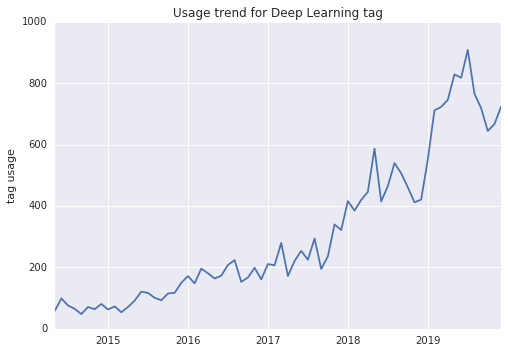

In [73]:
dl_df[dl_df['yearmonth'].dt.year<2020].plot.line(x='yearmonth', y='dl_tag', legend=False)
plt.title('Usage trend for Deep Learning tag')
plt.ylabel('tag usage')
plt.xlabel('')

Deep Learning is on the rise. Except for seasonal dips that happen at the year, this tag's usage increasing.